# XpertAI tutorial on the wine data set

In [2]:
import utils
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import torch.nn as nn

# Spanish Wine Dataset

In [4]:
df = pd.read_pickle("wine_data_set.pkl")
df.describe()

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,199.538235,377.075882,2010.610588,4.414647,530.321176,42.517059,152.036129,10.919412,4.262353,2.928235
std,121.510787,197.962653,11.713527,0.150778,1138.467085,12.199646,294.945928,3.612316,0.662184,0.313747
min,0.000000,0.000000,1910.000000,4.200000,25.000000,0.000000,6.260000,0.000000,2.000000,1.000000
25%,84.000000,201.000000,2010.000000,4.300000,56.000000,43.000000,33.000000,10.000000,4.000000,3.000000
50%,209.000000,408.500000,2015.000000,4.400000,134.000000,46.000000,58.255000,11.000000,4.000000,3.000000
75%,316.000000,545.250000,2017.000000,4.500000,506.500000,48.000000,126.027500,12.000000,5.000000,3.000000
max,394.000000,676.000000,2021.000000,4.900000,16505.000000,62.000000,3119.080000,20.000000,5.000000,3.000000


In [5]:
# Select and prepare data

target_='rating'
inputs_ = ['winery', 'wine', 'year', 'region', 'price', 'type', 'body', 'acidity']

scale = MinMaxScaler()
X = np.array(df[inputs_])
y = np.array(df[target_])

X = scale.fit_transform(X)
y = scale.fit_transform(y.reshape(-1,1)).T.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

Epoch [4999/5000], Loss: 0.0167, Val Loss: 0.0240


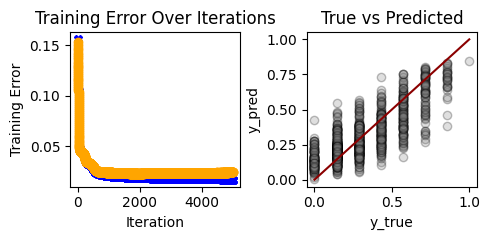

Pearson Correlation Coefficient: 0.7022


In [6]:
# Define and train original model f(x)

torch.manual_seed(444)

# Define the model
model = nn.Sequential(
    nn.Linear(8, 20),  # 5 inputs, 10 hidden units
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 1, bias=False)   # 10 hidden units, 1 output
)

model = utils.train_base(model, 
                         X_train, X_test, y_train, y_test, 
                         num_epochs=5000, 
                         print_every=4999)

correlation_coefficient = utils.pearson_corrcoef(torch.Tensor(y_test).flatten(), model(torch.Tensor(X_test)).flatten())
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")

Training head for range [0.00, 0.33]


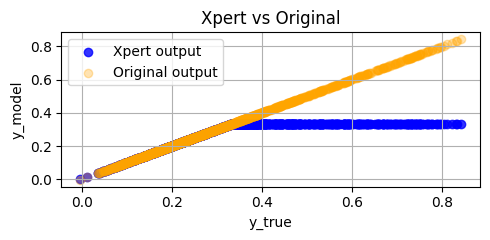

Training head for range [0.33, 0.66]
Epoch [1000/2500], Loss: 0.0006, Val Loss: 0.0021


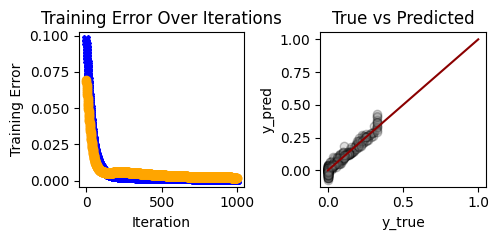

Epoch [2000/2500], Loss: 0.0004, Val Loss: 0.0016


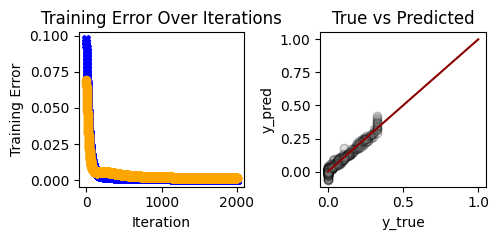

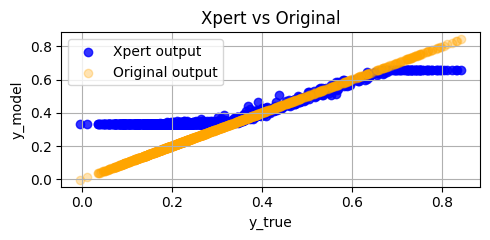

Training head for range [0.66, 0.99]
Epoch [1000/5000], Loss: 0.0082, Val Loss: 0.0258


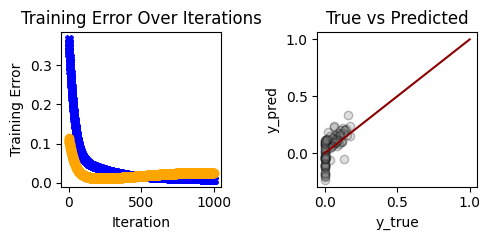

Epoch [2000/5000], Loss: 0.0050, Val Loss: 0.0154


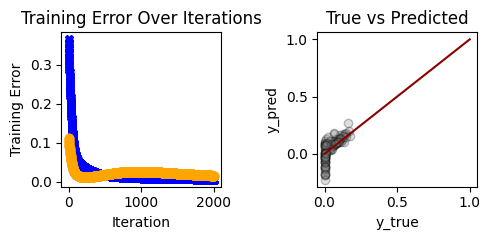

Epoch [3000/5000], Loss: 0.0033, Val Loss: 0.0072


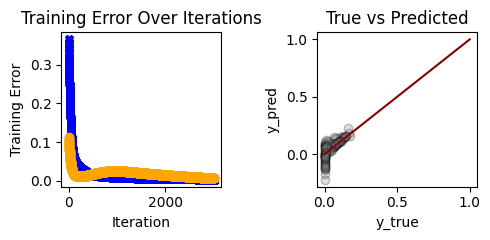

Epoch [4000/5000], Loss: 0.0018, Val Loss: 0.0033


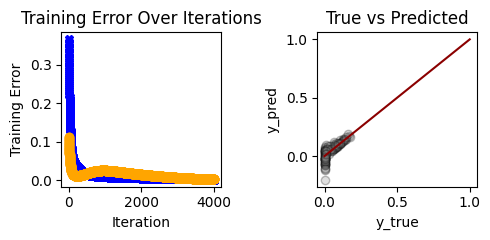

Epoch [5000/5000], Loss: 0.0006, Val Loss: 0.0026


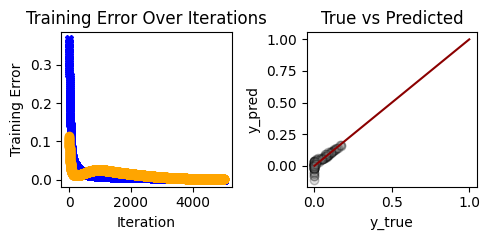

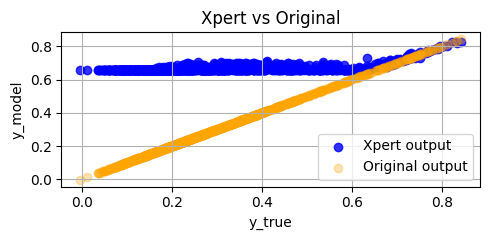

In [7]:
# define ranges and train XpertAI-heads

lst_ranges_heads=list(np.arange(0, 1.01, 0.33))

lst_heads = utils.train_heads(model,
                        X_train,
                        y_train,
                        lst_ranges_heads,
                        layer_freeze_head=6,
                        n_neurons_heads=20,
                        lr=1e-4,
                        base_steps=2500,
                        weight_decay=1e-10,
                        plot=True
                    )

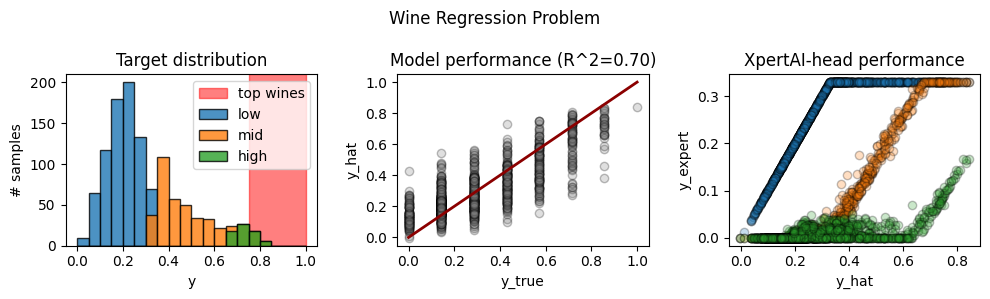

In [8]:
# plot overview

utils.plot_wine_regression_overview(model,
                              X_train, y_train,
                              lst_heads,
                              correlation_coefficient)

# Quantitative Eval

In [10]:
# conduct flipping experiment and report results

df_flip_res, att_naive, lst_att_heads = utils.evaluate_head_attributions(model,
                                                                    lst_heads,
                                                                    X_train,
                                                                    lst_ranges_heads,
                                                                    attribution_method="IG",
                                                                    baseline_fn=None,
                                                                    eval_top=350,
                                                                    n_baselines=10,
)

100%|████████████████████████████████████████| 350/350 [00:02<00:00, 157.73it/s]

average ABC naive: 0.38
average ABC XpertAI: 0.68
relative improvement: 77.0%


# Insights per Xpert

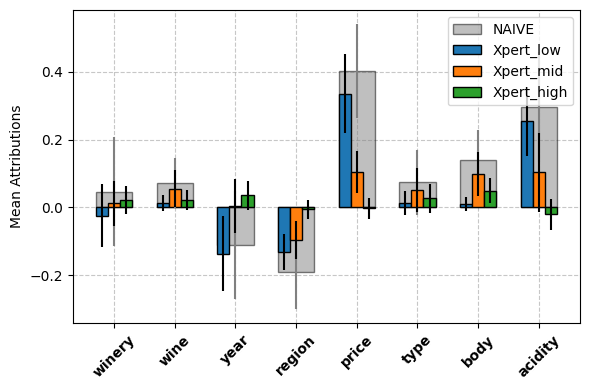

In [12]:
# visualize strategies of Xperts vs. the naive explanation

utils.plot_wine_attributions(
    model,
    X_train,
    att_naive,
    lst_att_heads,
    lst_heads,
    inputs_,
    weights=(0.33, 0.33, 0.125),
    top_threshold=0.75,
    save_path=None
)